# Basic Usage

## Evaluation

In [1]:
from eval_gnn import eval_gnn
from str2env import str2env

/home/wenjin/anaconda3/envs/gnnmp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pybullet build time: May 20 2022 19:44:17


In [2]:
# evaluation on the test cases
env, indexes = str2env('maze2hard')  # choose env among ('maze2easy', 'maze2hard', 'kuka7', 'ur5', 'snake7', 'kuka13', 'kuka14')
# evaluation with GNN
_ = eval_gnn(str(env), 1234, env=env, indexes=indexes, smooth=True, use_tqdm=True)

gnn 0.03s, search 0.60s, explored 69: 100%|██████████| 1000/1000 [05:48<00:00,  2.87it/s]

success rate: 1000
collision check: 2486.87
collision check explore: 2212.49
running time: 0.35
path cost: 2.19
total time: 345.96
total time explore: 321.19



# Advanced

## Generate New Dataset

In [3]:
from diversify_maze import find_mazes, INFINITY
import numpy as np
# generate 1000 test cases
maps, init_states, goal_states = find_mazes(10, density=[100, 150], dist2goal_threshold=1)
np.savez('maze_files/mazes_new_dataset.npz', maps=maps, goal_states=goal_states, init_states=init_states)

len of new data: 9:   0%|          | 30/10000000 [00:00<24:42:56, 112.39it/s]


## Test on New Environment

In [4]:
from tqdm import tqdm
from config import set_random_seed
from str2name import str2name
import torch
from eval_gnn import explore

from environment import MazeEnv
env = MazeEnv(dim=2, map_file='maze_files/mazes_new_dataset.npz')
indexes = range(0, 1000)
bs = 100  # only sample 100 points
results = []

_, model, model_path, model_s, model_s_path = str2name(str(env))
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model_s.load_state_dict(torch.load(model_s_path, map_location=torch.device("cpu")))
model.eval()
model_s.eval()

for i in tqdm(range(10)):
    
    env.init_new_problem(i)
    set_random_seed(1234)
    _, model, model_path, model_s, model_s_path = str2name(str(env))
    result = explore(env, model, model_s, smooth=True, smoother='none', batch=bs, t_max=bs, k=10) 
    
    results.append(result)

100%|██████████| 10/10 [00:01<00:00,  7.58it/s]


In [8]:
print(type(results[0]))
one_solution = results[0]

for key in one_solution:
    print(key)

print(key.smooth_path)

<class 'dict'>
c_explore
c_smooth
data
explored
forward
total
total_explore
success
t0
path
smooth_path
explored_edges


In [6]:
# get the collision numbers
c_explores = [r['c_explore'] for r in results]

<Figure size 640x480 with 0 Axes>

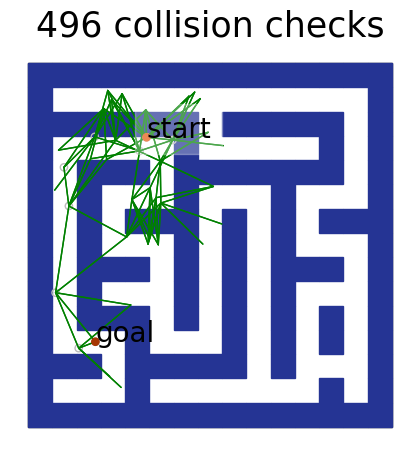

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.plot import plot_edges
i = np.argmin(c_explores)
env.init_new_problem(i)
edges = results[i]['data'].v[np.array(results[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
plot_edges(results[i]['path'], edges, env.get_problem(), \
           title='{0:d} collision checks'.format(results[i]['c_explore']), \
           save=None)
plt.show()

<Figure size 640x480 with 0 Axes>

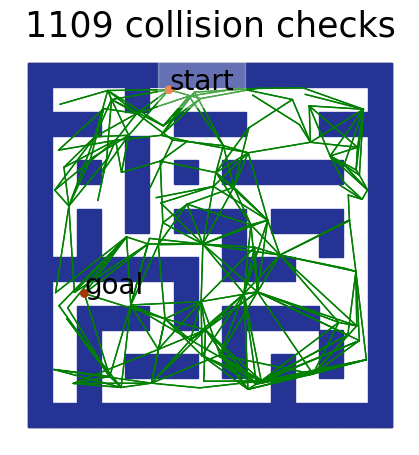

In [8]:
i = np.argmax(c_explores)
env.init_new_problem(i)
edges = results[i]['data'].v[np.array(results[i]['explored_edges']).reshape(-1)].reshape(-1, 2, 2)
edges = [[tuple(k), tuple(v)] for k, v in zip(edges[:, 0, :].cpu().numpy(), edges[:, 1, :].cpu().numpy())]
plot_edges(results[i]['path'], edges, env.get_problem(), \
           title='{0:d} collision checks'.format(results[i]['c_explore']), \
           save=None)
plt.show()